In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram
from neuropy.io.usvio import detect_tone

from tracefc.io.session_directory import get_session_dir
import tracefc.io.traceio as traceio

In [2]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Finn', 'recall1'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 4002.59 seconds 
duration: 1.11 hours 



## Read in movement data

In [5]:
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df["Time since rec start (sec)"] = (sync_df['Datetime'] - sync_df.loc[0, 'Datetime']).dt.total_seconds()
sync_df

start time = 2022-01-21 12:30:50.731508-05:00
start time = 2022-01-21 12:30:50.731508-05:00
Dropping last 7424 frames per dropped_end_frames.txt file
start time = 2022-01-21 12:36:53.592984-05:00
start time = 2022-01-21 12:59:46.424053-05:00
start time = 2022-01-21 13:28:32.606720-05:00


Recording                            Datetime Condition  nframe_dat  \
0          0    2022-01-21 12:30:50.731508-05:00     start           0   
1          0 2022-01-21 12:32:49.541074667-05:00      stop     3564287   
2          1 2022-01-21 12:34:38.989641333-05:00     start     3564288   
3          1 2022-01-21 12:35:11.074941333-05:00      stop     4526847   
4          2    2022-01-21 12:36:53.592984-05:00     start     4526848   
5          2 2022-01-21 12:57:43.478817333-05:00      stop    42023423   
6          3    2022-01-21 12:59:46.424053-05:00     start    42023424   
7          3    2022-01-21 13:24:41.139753-05:00      stop    86864895   
8          4    2022-01-21 13:28:32.606720-05:00     start    86864896   
9          4 2022-01-21 13:46:59.704286667-05:00      stop   120077823   

      dat_time  nframe_eeg   eeg_time  Time since rec start (sec)  
0     0.000000           0     0.0000                    0.000000  
1   118.809567      148511   118.8088                  118.809567  
2   118.809600      148512   118.8096                  228.258133  
3   150.894900      188618   150.8944                  260.343433  
4   150.894933      188619   150.8952                  362.861476  
5  1400.780767     1750975  1400.7800                 1612.747309  
6  1400.780800     1750976  1400.7808                 1735.692545  
7  2895.496500     3619370  2895.4960                 3230.408245  
8  2895.496533     3619371  2895.4968                 3461.875212  
9  4002.594100     5003242  4002.5936                 4568.972779

In [6]:
import neuropy.io.miniscopeio as miniio
mini = miniio.MiniscopeIO(sess.basepath)

In [7]:
mini.load_all_orientation()
mini.load_all_timestamps()

including folder /data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/1_tone_recall/Finn/gobears/2022_01_21/12_37_59
including folder /data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/1_tone_recall/Finn/gobears/2022_01_21/12_40_13
including folder /data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/1_tone_recall/Finn/gobears/2022_01_21/12_48_25
including folder /data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/2_control_tone_recall/Finn/gobears/2022_01_21/13_04_01
including folder /data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/2_control_tone_recall/Finn/gobears/2022_01_21/13_20_07
including folder /data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/3_ctx_recall/Finn/gobears/2022_01_21/13_31_46
including folder /data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/3_ctx_recall/Finn/gobears/2022_01_21/13_33_31
Eliminating timestamps from corrupted video0 in 12_37_59 folder.
Eliminating timestamps from corrupted video6 in 12_40_13 folder.


Frame Number  Time Stamp (ms)  Buffer Index              Timestamps
0                 0              -31             0 2022-01-21 12:40:13.454
1                 1               38             0 2022-01-21 12:40:13.523
2                 2              104             0 2022-01-21 12:40:13.589
3                 3              172             0 2022-01-21 12:40:13.657
4                 4              239             0 2022-01-21 12:40:13.724
...             ...              ...           ...                     ...
11149         11149           751196             0 2022-01-21 13:46:02.988
11150         11150           751263             0 2022-01-21 13:46:03.055
11151         11151           751332             0 2022-01-21 13:46:03.124
11152         11152           751398             0 2022-01-21 13:46:03.190
11153         11153           751466             0 2022-01-21 13:46:03.258

[42497 rows x 4 columns]

In [8]:
mini.orient_all

Time Stamp (ms)        qw        qx        qy        qz  \
0                  -64  0.879578  0.403748  0.251709  0.003052   
1                   30  0.888672  0.362976  0.279358  0.023071   
2                   73  0.922241  0.302429  0.238220  0.035034   
3                  138  0.929932  0.292480  0.219360  0.039490   
4                  206  0.899109  0.358521  0.240906  0.070862   
...                ...       ...       ...       ...       ...   
11149           751196  0.383667 -0.036926 -0.168701 -0.907166   
11150           751263  0.383606 -0.037353 -0.168762 -0.907166   
11151           751332  0.383545 -0.037537 -0.168884 -0.907166   
11152           751398  0.383545 -0.037598 -0.168945 -0.907166   
11153           751466  0.383850 -0.037781 -0.168701 -0.907104   

                   Timestamps      roll     pitch       yaw  
0     2022-01-21 12:37:59.774  0.915341  0.455965  0.234514  
1     2022-01-21 12:37:59.868  0.847983  0.500383  0.281595  
2     2022-01-21 12:37:59.911  0.684761  0.431466  0.231832  
3     2022-01-21 12:37:59.976  0.653723  0.395078  0.220381  
4     2022-01-21 12:38:00.044  0.825193  0.392383  0.330856  
...                       ...       ...       ...       ...  
11149 2022-01-21 13:46:02.988  0.287197 -0.197741 -2.370027  
11150 2022-01-21 13:46:03.055  0.287019 -0.198557 -2.370246  
11151 2022-01-21 13:46:03.124  0.287134 -0.198967 -2.370438  
11152 2022-01-21 13:46:03.190  0.287211 -0.199120 -2.370486  
11153 2022-01-21 13:46:03.258  0.286558 -0.199350 -2.369871  

[43342 rows x 9 columns]

In [9]:
sync_df

Recording                            Datetime Condition  nframe_dat  \
0          0    2022-01-21 12:30:50.731508-05:00     start           0   
1          0 2022-01-21 12:32:49.541074667-05:00      stop     3564287   
2          1 2022-01-21 12:34:38.989641333-05:00     start     3564288   
3          1 2022-01-21 12:35:11.074941333-05:00      stop     4526847   
4          2    2022-01-21 12:36:53.592984-05:00     start     4526848   
5          2 2022-01-21 12:57:43.478817333-05:00      stop    42023423   
6          3    2022-01-21 12:59:46.424053-05:00     start    42023424   
7          3    2022-01-21 13:24:41.139753-05:00      stop    86864895   
8          4    2022-01-21 13:28:32.606720-05:00     start    86864896   
9          4 2022-01-21 13:46:59.704286667-05:00      stop   120077823   

      dat_time  nframe_eeg   eeg_time  Time since rec start (sec)  
0     0.000000           0     0.0000                    0.000000  
1   118.809567      148511   118.8088                  118.809567  
2   118.809600      148512   118.8096                  228.258133  
3   150.894900      188618   150.8944                  260.343433  
4   150.894933      188619   150.8952                  362.861476  
5  1400.780767     1750975  1400.7800                 1612.747309  
6  1400.780800     1750976  1400.7808                 1735.692545  
7  2895.496500     3619370  2895.4960                 3230.408245  
8  2895.496533     3619371  2895.4968                 3461.875212  
9  4002.594100     5003242  4002.5936                 4568.972779

## Syncyhronize timescale

In [10]:
sync_df["Time since rec start (sec)"] = (sync_df['Datetime'] - sync_df.loc[0, 'Datetime']).dt.total_seconds()
sync_df

Recording                            Datetime Condition  nframe_dat  \
0          0    2022-01-21 12:30:50.731508-05:00     start           0   
1          0 2022-01-21 12:32:49.541074667-05:00      stop     3564287   
2          1 2022-01-21 12:34:38.989641333-05:00     start     3564288   
3          1 2022-01-21 12:35:11.074941333-05:00      stop     4526847   
4          2    2022-01-21 12:36:53.592984-05:00     start     4526848   
5          2 2022-01-21 12:57:43.478817333-05:00      stop    42023423   
6          3    2022-01-21 12:59:46.424053-05:00     start    42023424   
7          3    2022-01-21 13:24:41.139753-05:00      stop    86864895   
8          4    2022-01-21 13:28:32.606720-05:00     start    86864896   
9          4 2022-01-21 13:46:59.704286667-05:00      stop   120077823   

      dat_time  nframe_eeg   eeg_time  Time since rec start (sec)  
0     0.000000           0     0.0000                    0.000000  
1   118.809567      148511   118.8088                  118.809567  
2   118.809600      148512   118.8096                  228.258133  
3   150.894900      188618   150.8944                  260.343433  
4   150.894933      188619   150.8952                  362.861476  
5  1400.780767     1750975  1400.7800                 1612.747309  
6  1400.780800     1750976  1400.7808                 1735.692545  
7  2895.496500     3619370  2895.4960                 3230.408245  
8  2895.496533     3619371  2895.4968                 3461.875212  
9  4002.594100     5003242  4002.5936                 4568.972779

In [11]:
sess.filePrefix

PosixPath('/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_denoised')

In [12]:
### Bowen copy to properly interpolate

rough_headsensor_times = (mini.orient_all["Timestamps"].dt.tz_localize(tz="America/Detroit") - sync_df.loc[0, "Datetime"]).dt.total_seconds()
mini.orient_all["Time from OE start"] = rough_headsensor_times
mini.orient_all

# Key line of code - converts miniscope time (which doesn't account for disconnects) to eeg time (which cuts out disconnect times)
mini.orient_all["Rough eeg time (s)"] = np.interp(mini.orient_all["Time from OE start"], sync_df["Time since rec start (sec)"], 
                                            sync_df["eeg_time"])
mini.orient_all

Time Stamp (ms)        qw        qx        qy        qz  \
0                  -64  0.879578  0.403748  0.251709  0.003052   
1                   30  0.888672  0.362976  0.279358  0.023071   
2                   73  0.922241  0.302429  0.238220  0.035034   
3                  138  0.929932  0.292480  0.219360  0.039490   
4                  206  0.899109  0.358521  0.240906  0.070862   
...                ...       ...       ...       ...       ...   
11149           751196  0.383667 -0.036926 -0.168701 -0.907166   
11150           751263  0.383606 -0.037353 -0.168762 -0.907166   
11151           751332  0.383545 -0.037537 -0.168884 -0.907166   
11152           751398  0.383545 -0.037598 -0.168945 -0.907166   
11153           751466  0.383850 -0.037781 -0.168701 -0.907104   

                   Timestamps      roll     pitch       yaw  \
0     2022-01-21 12:37:59.774  0.915341  0.455965  0.234514   
1     2022-01-21 12:37:59.868  0.847983  0.500383  0.281595   
2     2022-01-21 12:37:59.911  0.684761  0.431466  0.231832   
3     2022-01-21 12:37:59.976  0.653723  0.395078  0.220381   
4     2022-01-21 12:38:00.044  0.825193  0.392383  0.330856   
...                       ...       ...       ...       ...   
11149 2022-01-21 13:46:02.988  0.287197 -0.197741 -2.370027   
11150 2022-01-21 13:46:03.055  0.287019 -0.198557 -2.370246   
11151 2022-01-21 13:46:03.124  0.287134 -0.198967 -2.370438   
11152 2022-01-21 13:46:03.190  0.287211 -0.199120 -2.370486   
11153 2022-01-21 13:46:03.258  0.286558 -0.199350 -2.369871   

       Time from OE start  Rough eeg time (s)  
0              429.042492          217.076161  
1              429.136492          217.170161  
2              429.179492          217.213161  
3              429.244492          217.278161  
4              429.312492          217.346161  
...                   ...                 ...  
11149         4512.256492         3945.877353  
11150         4512.323492         3945.944353  
11151         4512.392492         3946.013353  
11152         4512.458492         3946.079352  
11153         4512.526492         3946.147352  

[43342 rows x 11 columns]

## Read in CS+, CS-, CS2 time

In [13]:
cs_epochs_file = sess.filePrefix.with_suffix(".cs_epochs.npy")
sess.cs_epochs = Epoch(epochs=None, file=cs_epochs_file)
sess.cs_epochs.starts

array([ 277.541349,  357.476082,  421.423949,  481.373649,  542.302849,
        605.253449,  671.204016,  734.134049,  806.090249,  874.035149,
        950.966249, 1028.916249, 1108.866616, 1182.795682, 1260.746482])

In [14]:
csn_epochs_file = sess.filePrefix.with_suffix(".csn_epochs.npy")
sess.csn_epochs = Epoch(epochs=None, file=csn_epochs_file)
sess.csn_epochs.starts

array([1724.656747, 1792.58128 , 1858.531113, 1925.481846, 2001.413313,
       2068.36188 , 2132.31168 , 2212.24408 , 2272.191813, 2352.143913,
       2418.071847, 2495.023813])

In [15]:
cs2_epochs_file = sess.filePrefix.with_suffix(".cs2_epochs.npy")
sess.cs2_epochs = Epoch(epochs=None, file=cs2_epochs_file)
sess.cs2_epochs.starts

array([2555.970747, 2622.90188 , 2683.85078 ])

In [16]:
1725-1656

69

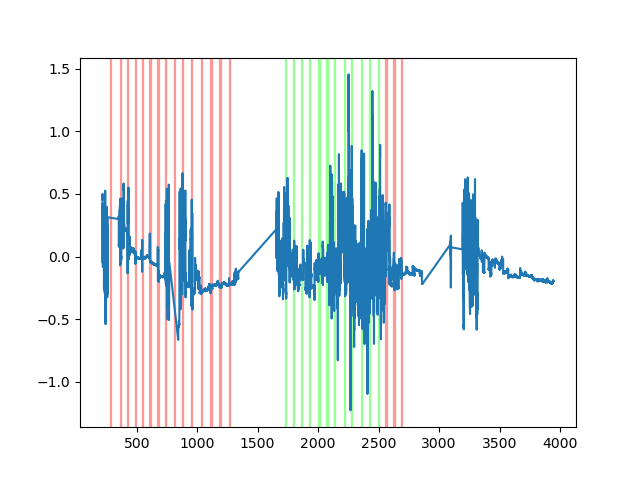

In [17]:
%matplotlib widget
_, ax = plt.subplots()
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all.pitch)
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1, 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

## Calculate head movement speed

In [18]:
def calc_head_speed(df):

    angle_diffs = []
    for ang_axis in ["roll", "pitch", "yaw"]:
        axis_diff = df[ang_axis].diff()

        # Correct any swings of > 2*pi
        axis_diff[axis_diff > 1.8 * np.pi] = axis_diff[axis_diff > 1.8 * np.pi] - 2 * np.pi
        axis_diff[axis_diff < -1.8 * np.pi] = axis_diff[axis_diff < -1.8 * np.pi] + 2 * np.pi
        angle_diffs.append(axis_diff.values)
    # head_speed = np.sqrt(np.square(df.roll.diff()) + np.square(df.pitch.diff()) + np.square(df.yaw.diff())) / df["Rough eeg time (s)"].diff()
    head_speed = np.sqrt(np.square(angle_diffs[0]) + np.square(angle_diffs[1]) + np.square(angle_diffs[2]))
    return head_speed
calc_head_speed(mini.orient_all)

array([           nan, 9.34168482e-02, 1.84030224e-01, ...,
       4.67501637e-04, 1.77194059e-04, 9.25861556e-04])

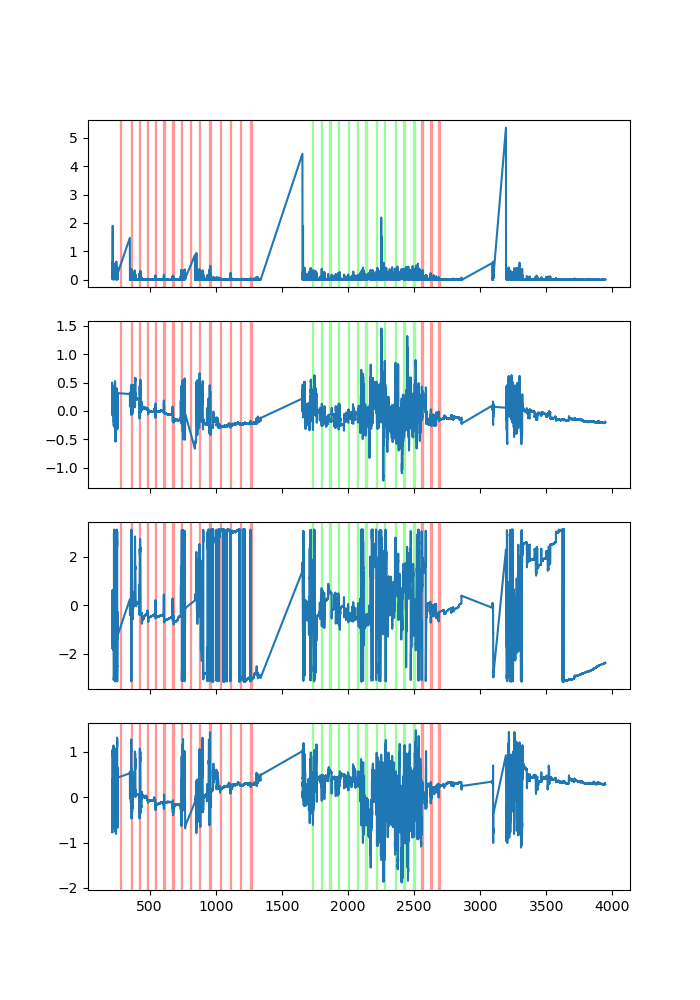

In [19]:
%matplotlib widget
_, axs = plt.subplots(4, 1, figsize=(7, 10), sharex=True)
ax = axs[0]
mini.orient_all["Head speed"] = calc_head_speed(mini.orient_all)
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all["Head speed"])
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1, 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

ax = axs[1]
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all.pitch)
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1, 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

ax = axs[2]
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all.yaw)
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1, 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

ax = axs[3]
ax.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all.roll)
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax.axvspan(start, stop, color=[0, 1, 0, 0.3])

for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax.axvspan(start, stop, color=[1, 0, 0, 0.3])

In [20]:
sess.cs_epochs.starts

array([ 277.541349,  357.476082,  421.423949,  481.373649,  542.302849,
        605.253449,  671.204016,  734.134049,  806.090249,  874.035149,
        950.966249, 1028.916249, 1108.866616, 1182.795682, 1260.746482])

/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_denoised.probegroup.npy saved


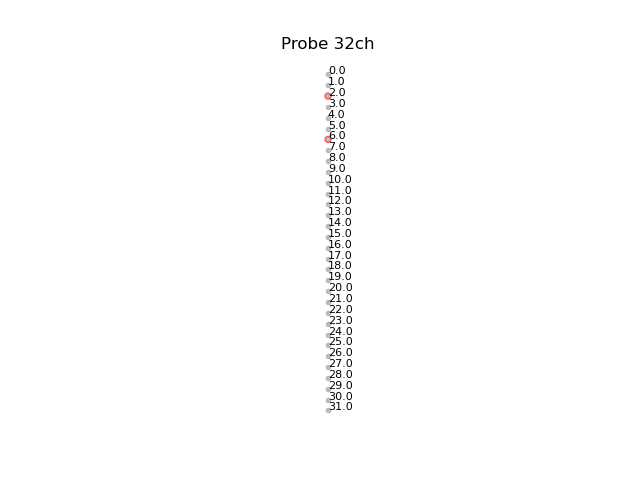

In [21]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

## Read in theta power

In [22]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=31), thresh=11, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()


from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 24

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

from neuropy.analyses.oscillations import detect_ripple_epochs
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta
ripple_channel = 24
if not exclude_theta_epochs:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs)
else:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs))

/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Existing artifact epochs file loaded
Total artifact time = 124.4 seconds
Best channel for theta: [24]
327 epochs remaining with durations within (1,20)
Selected channels for ripples: [24]
1995 epochs remaining with durations within (0.05,0.45)


In [23]:
mini.orient_all

Time Stamp (ms)        qw        qx        qy        qz  \
0                  -64  0.879578  0.403748  0.251709  0.003052   
1                   30  0.888672  0.362976  0.279358  0.023071   
2                   73  0.922241  0.302429  0.238220  0.035034   
3                  138  0.929932  0.292480  0.219360  0.039490   
4                  206  0.899109  0.358521  0.240906  0.070862   
...                ...       ...       ...       ...       ...   
11149           751196  0.383667 -0.036926 -0.168701 -0.907166   
11150           751263  0.383606 -0.037353 -0.168762 -0.907166   
11151           751332  0.383545 -0.037537 -0.168884 -0.907166   
11152           751398  0.383545 -0.037598 -0.168945 -0.907166   
11153           751466  0.383850 -0.037781 -0.168701 -0.907104   

                   Timestamps      roll     pitch       yaw  \
0     2022-01-21 12:37:59.774  0.915341  0.455965  0.234514   
1     2022-01-21 12:37:59.868  0.847983  0.500383  0.281595   
2     2022-01-21 12:37:59.911  0.684761  0.431466  0.231832   
3     2022-01-21 12:37:59.976  0.653723  0.395078  0.220381   
4     2022-01-21 12:38:00.044  0.825193  0.392383  0.330856   
...                       ...       ...       ...       ...   
11149 2022-01-21 13:46:02.988  0.287197 -0.197741 -2.370027   
11150 2022-01-21 13:46:03.055  0.287019 -0.198557 -2.370246   
11151 2022-01-21 13:46:03.124  0.287134 -0.198967 -2.370438   
11152 2022-01-21 13:46:03.190  0.287211 -0.199120 -2.370486   
11153 2022-01-21 13:46:03.258  0.286558 -0.199350 -2.369871   

       Time from OE start  Rough eeg time (s)  Head speed  
0              429.042492          217.076161         NaN  
1              429.136492          217.170161    0.093417  
2              429.179492          217.213161    0.184030  
3              429.244492          217.278161    0.049179  
4              429.312492          217.346161    0.203994  
...                   ...                 ...         ...  
11149         4512.256492         3945.877353    0.002090  
11150         4512.323492         3945.944353    0.000863  
11151         4512.392492         3946.013353    0.000468  
11152         4512.458492         3946.079352    0.000177  
11153         4512.526492         3946.147352    0.000926  

[43342 rows x 12 columns]

In [24]:
# Run wavelet on theta range
theta_range = np.arange(4, 14, 0.25)  # How do I select these? 0.25Hz seems good to start
wv_theta = WaveletSg(signal.time_slice(channel_id=theta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=theta_range, sigma=None)

## Plot moving speed and theta power together

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

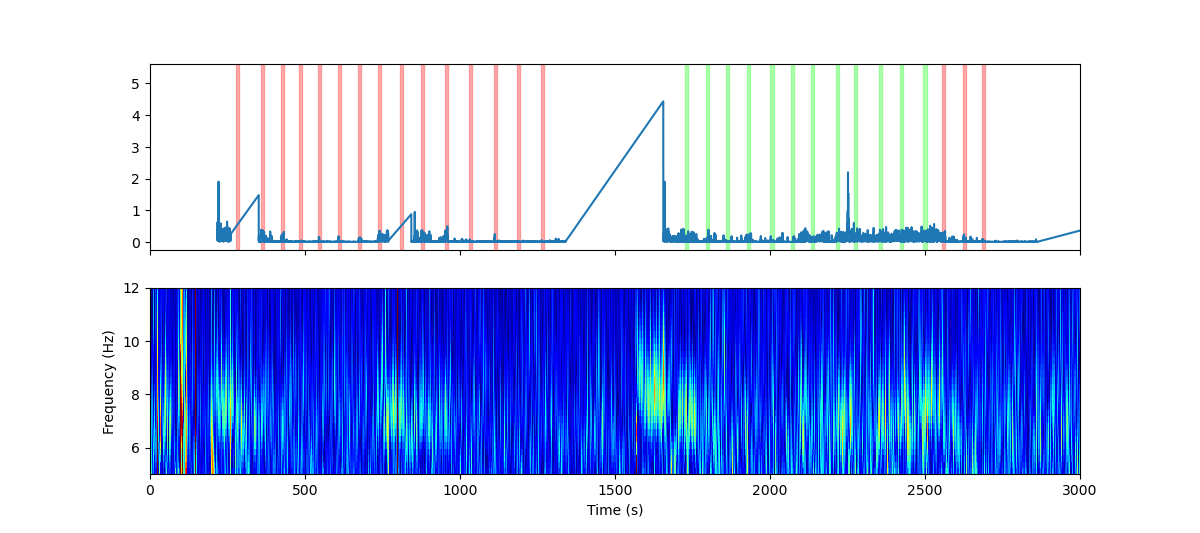

In [25]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(2, 1, figsize=(12,5.333), sharex=True)
time_to_plot = [0, 3000]
theta_freq_lims = [5, 12]

ax1 = axs[0]
mini.orient_all["Head speed"] = calc_head_speed(mini.orient_all)
ax1.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all["Head speed"])
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax1.axvspan(start, stop, color=[1, 0, 0, 0.3])
for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax1.axvspan(start, stop, color=[0, 1, 0, 0.3])
for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax1.axvspan(start, stop, color=[1, 0, 0, 0.3])


ax2 = axs[1]
plot_spectrogram(wv_theta, time_lims=time_to_plot, freq_lims=theta_freq_lims, ax=ax2)

plt.show()


In [26]:
start_buffer, stop_buffer = 10, 50
start = sess.cs_epochs.starts[1]
stop = sess.cs_epochs.stops[1]
eeg_times = mini.orient_all["Rough eeg time (s)"]
trial_bool = (eeg_times > (start - start_buffer)) & (eeg_times < (stop + stop_buffer))
mini.orient_all.loc[trial_bool, "Head speed"]

0      1.475932
1      0.031126
2      0.049827
3      0.063954
4      0.051704
         ...   
985    0.001985
986    0.005222
987    0.003439
988    0.004858
989    0.003223
Name: Head speed, Length: 990, dtype: float64

In [27]:
eeg_times

0         217.076161
1         217.170161
2         217.213161
3         217.278161
4         217.346161
            ...     
11149    3945.877353
11150    3945.944353
11151    3946.013353
11152    3946.079352
11153    3946.147352
Name: Rough eeg time (s), Length: 43342, dtype: float64

## Plot mean speed and mean theta power during CS+ and CS-

/tmp/ipykernel_2446705/1191486386.py:30: RuntimeWarning: Mean of empty slice
  average_speed = np.nanmean(all_speeds, axis=0)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

/tmp/ipykernel_2446705/1191486386.py:60: RuntimeWarning: Mean of empty slice
  average_speed = np.nanmean(all_speeds, axis=0)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

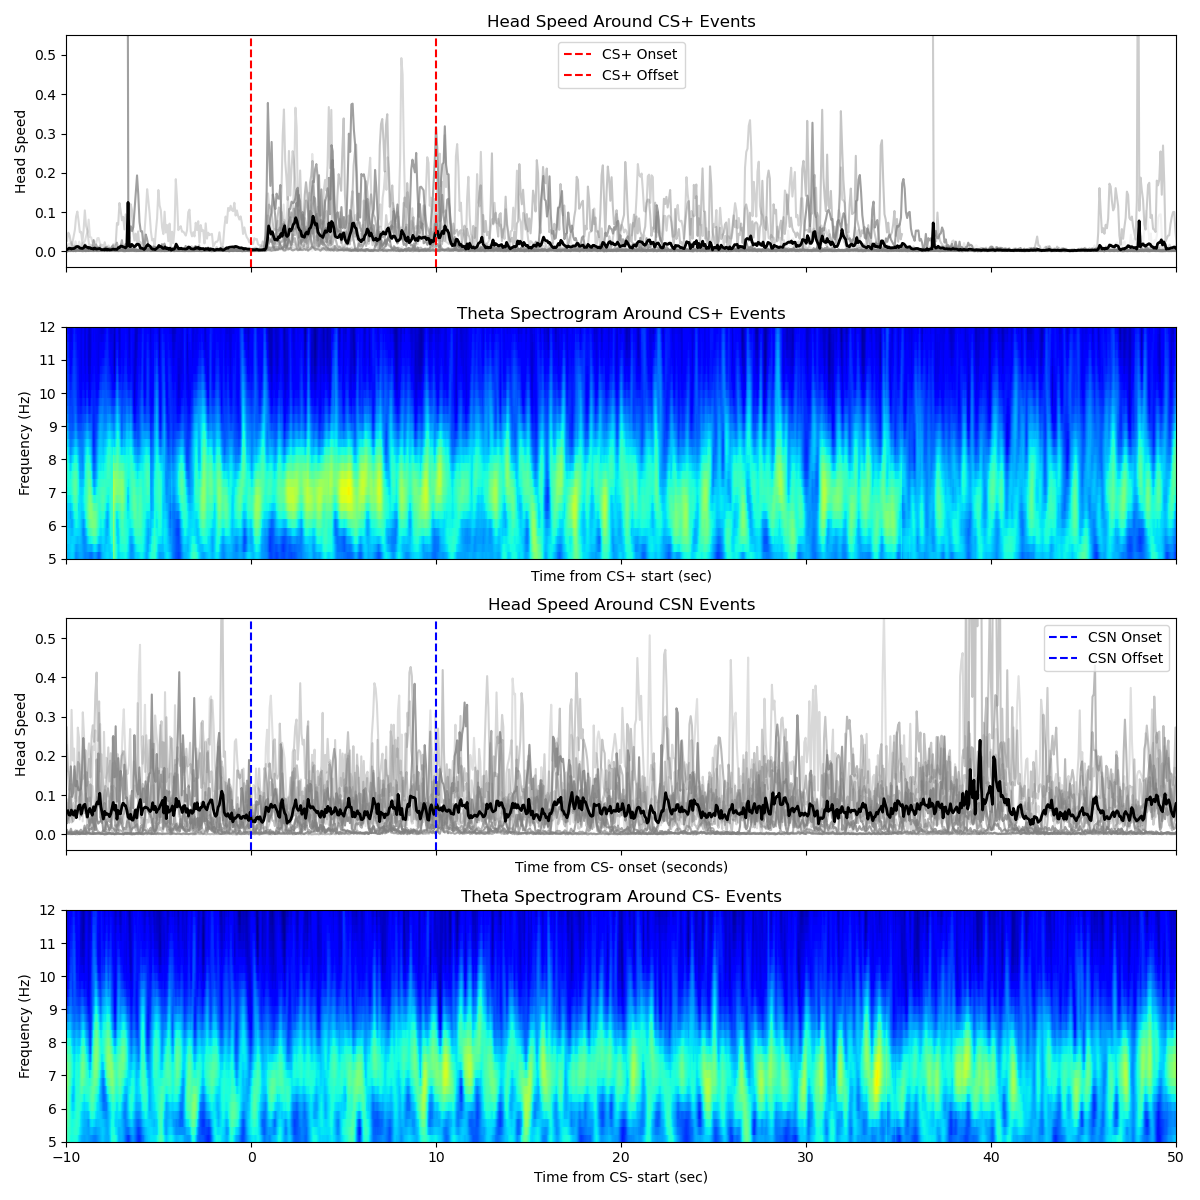

In [30]:
import matplotlib.pyplot as plt
import numpy as np

sampling_rate = 30
theta_freq_lims = [5, 12]  
usv_buffer_sec = (10, 50)  

fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Head Speed for CS+ in the first subplot
ax1 = axs[0]
epochs_use = sess.cs_epochs
eeg_times = mini.orient_all["Rough eeg time (s)"]
mini_sr = 15  # fps
start_buffer = 10
stop_buffer = 50

tinterp = np.arange(-start_buffer, (10 + stop_buffer) + 1/mini_sr, 1/mini_sr)
all_speeds = np.ones((epochs_use.n_epochs, len(tinterp)))*np.nan

for idt, (start, stop) in enumerate(zip(epochs_use.starts, epochs_use.stops)):
    trial_bool = (eeg_times > (start - start_buffer)) & (eeg_times < (stop + stop_buffer))
    speeds = mini.orient_all.loc[trial_bool, "Head speed"].values
    times = mini.orient_all.loc[trial_bool, "Rough eeg time (s)"].values - start

    ax1.plot(times, speeds, color='grey', alpha=0.8 - idt*0.05)
    data_bin_id = np.digitize(times, tinterp)
    all_speeds[idt, data_bin_id] = speeds

average_speed = np.nanmean(all_speeds, axis=0)
ax1.plot(tinterp, average_speed, color='black', linewidth=2)
ax1.axvline(x=0, color='red', linestyle='--', label='CS+ Onset')
ax1.axvline(x=10, color='red', linestyle='--', label='CS+ Offset')
ax1.set_ylabel('Head Speed')
ax1.set_title('Head Speed Around CS+ Events')
ax1.legend()
ax1.set_ylim(bottom=-0.04, top=0.55)

# Theta Power Spectrogram in the second subplot
ax3 = axs[1]
wv_theta_mean_cs = wv_theta.get_pe_mean_spec(sess.cs_epochs.starts, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs, print_ignored_frames=False)
plot_spectrogram(wv_theta_mean_cs, np.multiply(usv_buffer_sec, (-1, 1)), theta_freq_lims, ax3)
ax3.set_xlabel('Time from CS+ start (sec)')
ax3.set_title('Theta Spectrogram Around CS+ Events')

# Head Speed for CS- in the third subplot
ax2 = axs[2]
epochs_use = sess.csn_epochs
all_speeds = np.ones((epochs_use.n_epochs, len(tinterp)))*np.nan

for idt, (start, stop) in enumerate(zip(epochs_use.starts, epochs_use.stops)):
    trial_bool = (eeg_times > (start - start_buffer)) & (eeg_times < (stop + stop_buffer))
    speeds = mini.orient_all.loc[trial_bool, "Head speed"].values
    times = mini.orient_all.loc[trial_bool, "Rough eeg time (s)"].values - start

    ax2.plot(times, speeds, color='grey', alpha=0.8 - idt*0.05)
    data_bin_id = np.digitize(times, tinterp)
    all_speeds[idt, data_bin_id] = speeds

average_speed = np.nanmean(all_speeds, axis=0)
ax2.plot(tinterp, average_speed, color='black', linewidth=2)
ax2.axvline(x=0, color='blue', linestyle='--', label='CSN Onset')
ax2.axvline(x=10, color='blue', linestyle='--', label='CSN Offset')
ax2.set_xlabel('Time from CS- onset (seconds)')
ax2.set_ylabel('Head Speed')
ax2.set_title('Head Speed Around CSN Events')
ax2.legend()
ax2.set_ylim(bottom=-0.04, top=0.55)

# Theta Power Spectrogram for CS- in the fourth subplot
ax4 = axs[3]
wv_theta_mean_csn = wv_theta.get_pe_mean_spec(sess.csn_epochs.starts, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs, print_ignored_frames=False)
plot_spectrogram(wv_theta_mean_csn, np.multiply(usv_buffer_sec, (-1, 1)), theta_freq_lims, ax4)
ax4.set_xlabel('Time from CS- start (sec)')
ax4.set_title('Theta Spectrogram Around CS- Events')

plt.tight_layout()
plt.show()


## Read in SWR power

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

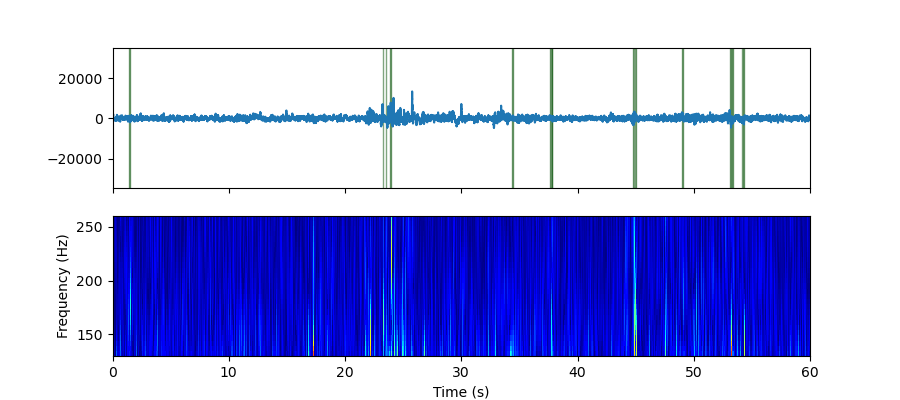

In [31]:
swr_range = np.arange(125, 275, 5)
wv_swr = WaveletSg(signal.time_slice(channel_id=ripple_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=swr_range, sigma=None)
# Sanity check code - does wavelet align well with actual SWR epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
swr_freq_lims = [130, 260]

plot_signal_w_epochs(signal, ripple_channel, ripple_epochs, ax=ax[0])

plot_spectrogram(wv_swr, time_lims=time_to_plot, freq_lims=swr_freq_lims, ax=ax[1])

## Plot CS epochs and SWR power together

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

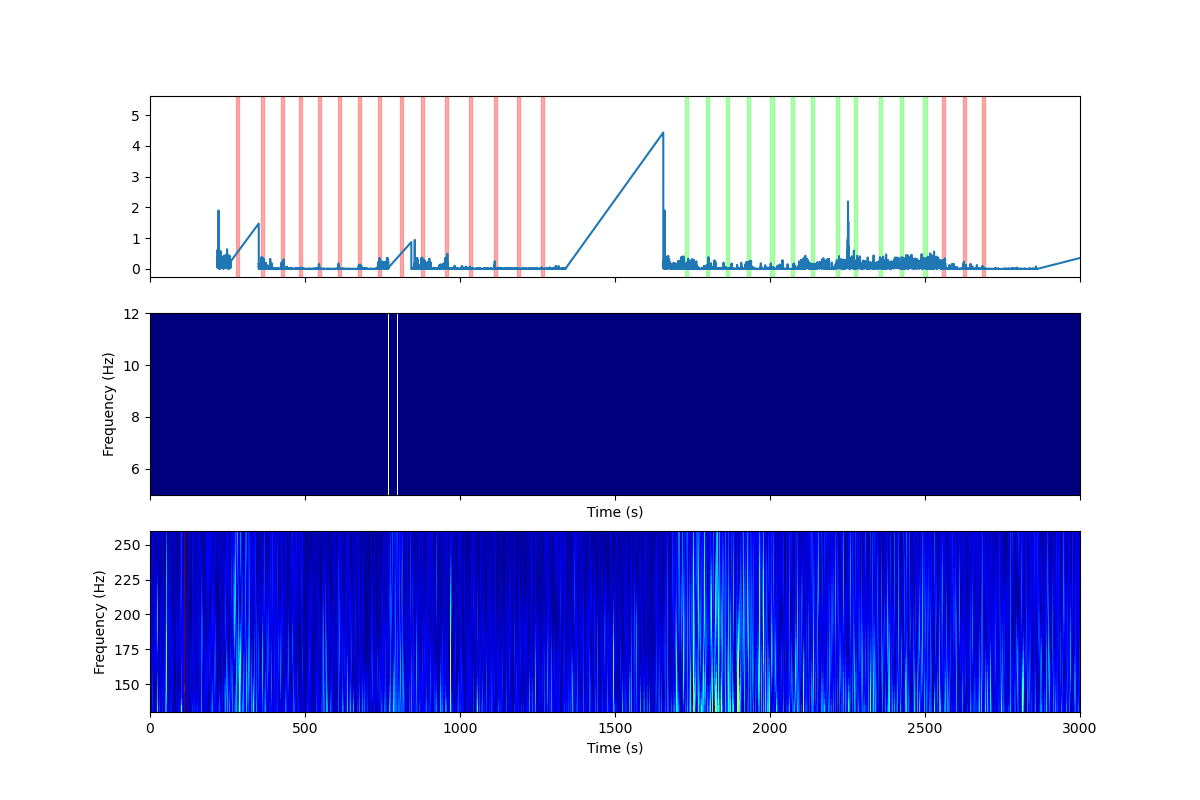

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate head speed
def calc_head_speed(data):
    # Implement the head speed calculation here
    return data["Head speed"]

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# First plot: Head speed with shaded epochs
time_to_plot = [0, 3000]
theta_freq_lims = [5, 12]

ax1 = axs[0]
mini.orient_all["Head speed"] = calc_head_speed(mini.orient_all)
ax1.plot(mini.orient_all["Rough eeg time (s)"], mini.orient_all["Head speed"])
for start, stop in zip(sess.cs_epochs.starts, sess.cs_epochs.stops):
    ax1.axvspan(start, stop, color=[1, 0, 0, 0.3])
for start, stop in zip(sess.csn_epochs.starts, sess.csn_epochs.stops):
    ax1.axvspan(start, stop, color=[0, 1, 0, 0.3])
for start, stop in zip(sess.cs2_epochs.starts, sess.cs2_epochs.stops):
    ax1.axvspan(start, stop, color=[1, 0, 0, 0.3])

# Second plot: Theta spectrogram
ax2 = axs[1]
plot_spectrogram(wv_theta, time_lims=time_to_plot, freq_lims=theta_freq_lims, ax=ax2)

# Third plot: SWR spectrogram
swr_range = np.arange(125, 275, 5)
wv_swr = WaveletSg(signal.time_slice(channel_id=ripple_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=swr_range, sigma=None)
swr_freq_lims = [130, 260]

ax3 = axs[2]
plot_spectrogram(wv_swr, time_lims=time_to_plot, freq_lims=swr_freq_lims, ax=ax3)

plt.show()

## Theta power at CS+ start

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from CS+ start (sec)')

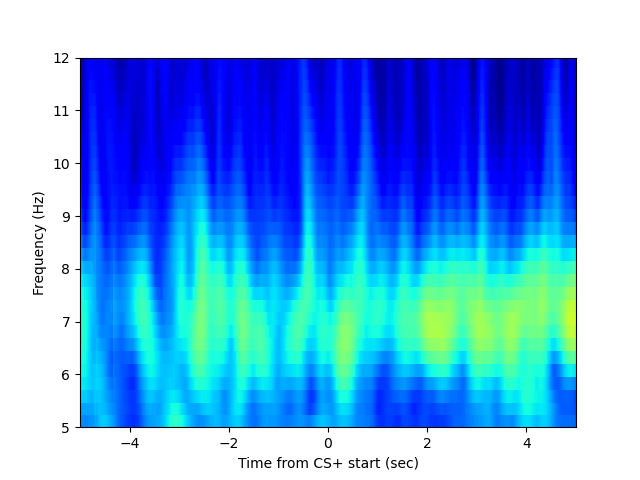

In [33]:
# Example code to plot theta at CS+ starts
usv_buffer_sec = (5,5)
wv_theta_mean = wv_theta.get_pe_mean_spec(sess.cs_epochs.starts, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from CS+ start (sec)')

## Theta power at CS+ stop

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from CS+ stop (sec)')

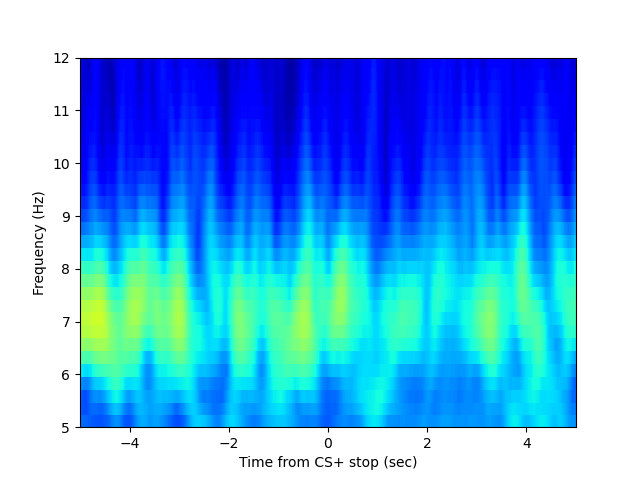

In [34]:
# Example code to plot theta at CS+ stops
usv_buffer_sec = (5,5)
wv_theta_mean = wv_theta.get_pe_mean_spec(sess.cs_epochs.stops, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from CS+ stop (sec)')

## Theta power at CS- start

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from CS- start (sec)')

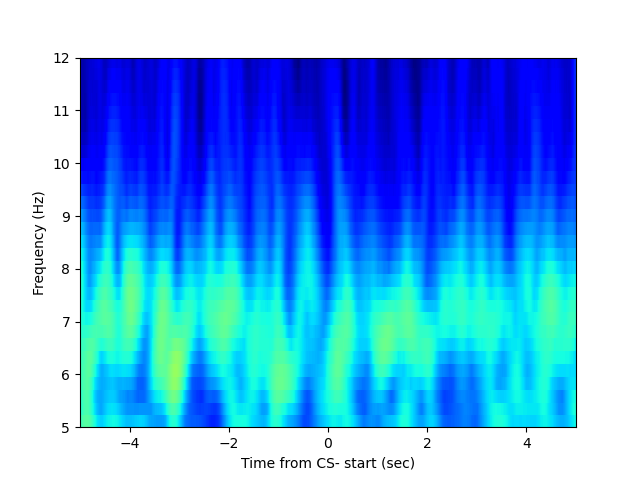

In [35]:
# Example code to plot theta at CS- starts
usv_buffer_sec = (5,5)
wv_theta_mean = wv_theta.get_pe_mean_spec(sess.csn_epochs.starts, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from CS- start (sec)')

## Theta power at CS- stop

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from CS- stop (sec)')

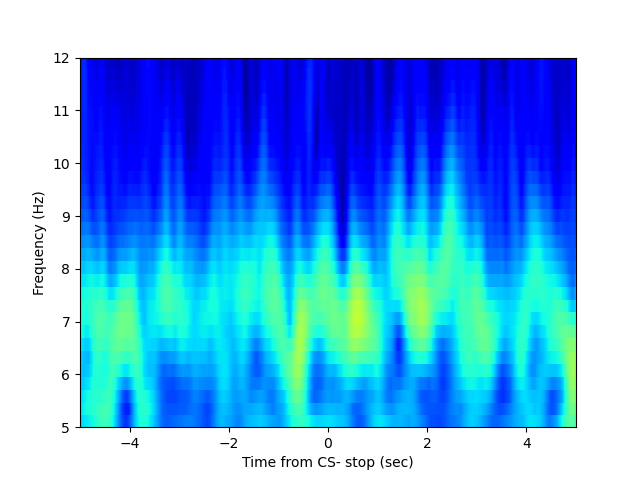

In [36]:
# Example code to plot theta at CS- stops
usv_buffer_sec = (5,5)
wv_theta_mean = wv_theta.get_pe_mean_spec(sess.csn_epochs.stops, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from CS- stop (sec)')

## Save notebook to animal working directory

In [37]:
from neuropy.utils.manipulate_files import save_notebook
try:
    save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")
except PermissionError:
    print('Got a weird PermissionError. Check to make sure file saved successfully')

/data/GitHub/TraceFC/Notebooks/Animal_files/Recall1 Notebooks/Rec1-Sync_USV_and_Ephys_archive(Finn).ipynb saved to /data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_Rec1-Sync_USV_and_Ephys_archive(Finn).ipynb


### Load in disconnect and motion artifacts

In [38]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=31), thresh=11, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 124.4 seconds


start       stop label  duration
0     24.0672    25.9024  None    1.8352
1     91.8944   123.9360  None   32.0416
2    131.7952   132.6608  None    0.8656
3    144.3256   151.7920  None    7.4664
4    203.8240   210.6336  None    6.8096
5    211.3012   211.8252  None    0.5240
6    218.6744   222.6064  None    3.9320
7    259.6192   260.7936  None    1.1744
8    272.0784   272.3000  None    0.2216
9    272.8732   273.2140  None    0.3408
10   769.3240   769.7072  None    0.3832
11   790.6728   798.6200  None    7.9472
12  1400.5000  1401.0000  None    0.5000
13  1566.5040  1571.8424  None    5.3384
14  1586.4864  1587.0192  None    0.5328
15  2035.8144  2036.2000  None    0.3856
16  2988.8392  2994.7320  None    5.8928
17  3055.3752  3055.6248  None    0.2496
18  3098.0388  3129.3604  None   31.3216
19  3135.5080  3135.8840  None    0.3760
20  3145.9064  3147.6544  None    1.7480
21  3156.8376  3157.1056  None    0.2680
22  3164.5880  3165.0176  None    0.4296
23  3179.2088  3179.5168  None    0.3080
24  3202.3104  3202.5664  None    0.2560
25  3249.6016  3249.8568  None    0.2552
26  3267.0960  3267.3776  None    0.2816
27  3295.3648  3303.3136  None    7.9488
28  3337.8832  3338.1432  None    0.2600
29  3347.8144  3348.7160  None    0.9016
30  3350.5488  3351.1872  None    0.6384
31  3736.0000  3739.0000  None    3.0000

<Axes: >

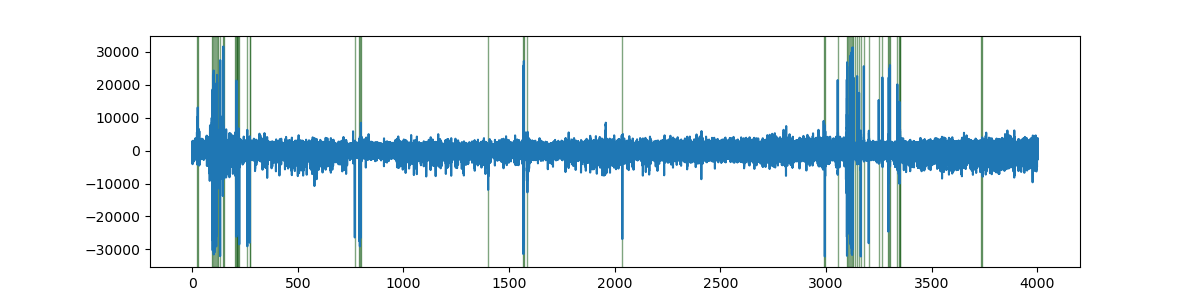

In [39]:
%matplotlib widget

chan_plot = 28
plot_signal_w_epochs(signal, 28, art_epochs)

## Define probe group

/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_denoised.probegroup.npy saved


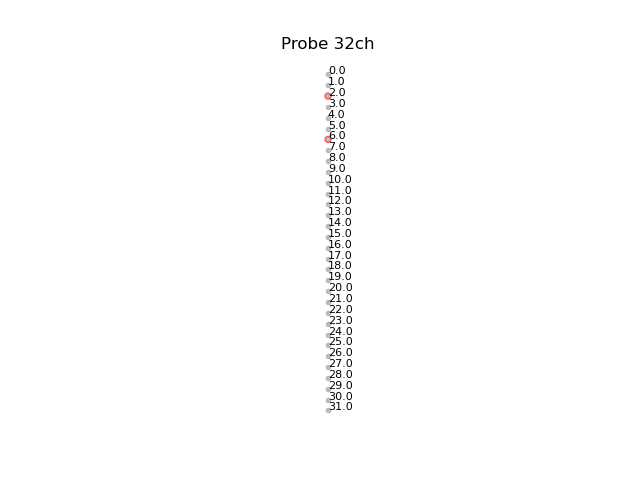

In [40]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=20, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

## Detect Theta epochs

In [41]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 24
# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for theta: [24]
327 epochs remaining with durations within (1,20)


## Detect SWR Epochs

In [42]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 24
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                     ignore_epochs=art_epochs)


Selected channels for ripples: [24]
1995 epochs remaining with durations within (0.05,0.45)


## Detect Delta

In [43]:
#Detect Delta
from neuropy.analyses.oscillations import detect_hpc_delta_wave_epochs
min_dur = 0.15  
max_dur = 0.5   
ignore_epochs = None  
delta_channel = 24  

freq_band = (0.5, 4)

if delta_channel is not None:
    signal_use = signal.time_slice(channel_id=delta_channel)
else:
    signal_use = signal
delta_epochs = detect_hpc_delta_wave_epochs(
    signal_use, freq_band=freq_band, min_dur=min_dur, max_dur=max_dur, ignore_epochs=ignore_epochs
)

159 delta waves detected


In [44]:
#Detect Beta
from neuropy.analyses.oscillations import detect_beta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
beta_channel = 24
  
if beta_channel is None:
    beta_epochs, beta_power = detect_beta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=beta_channel)
    beta_epochs, beta_power = detect_beta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for beta: [24]
325 epochs remaining with durations within (1,20)


In [45]:
# Detect Gamma
from neuropy.analyses.oscillations import detect_gamma_epochs
from neuropy.analyses.oscillations import Gamma
band=(40, 80)
lowthresh = 1.5  
highthresh = 3 
minDistance = 300
minDuration = 125
gamma_channel = 24

# Use this if you don't know the specific channel for gamma detection
if gamma_channel is None:
    signal_use = signal.time_slice(channel_id=gamma_channel)
else:
    # If a specific channel for gamma is known
    signal_use = signal

gammadetect = Gamma()
# gammadetect.get_peak_intervals(signal.traces, lowthresh=lowthresh, highthresh=highthresh, minDistance=minDistance, minDuration=minDuration)
peakevents, gamma_amp = Gamma().get_peak_intervals(signal_use.traces[gamma_channel, :], band=band, lowthresh=lowthresh, highthresh=highthresh, 
                                        minDistance=minDistance, minDuration=minDuration, return_amplitude=True)
# csd=csd(self, period, refchan, band=band, window=1250)
gamma_epochs = Epoch(pd.DataFrame({"start" : peakevents[:, 0]/sess.eegfile.sampling_rate, "stop": peakevents[:, 1]/sess.eegfile.sampling_rate,
                   "label": ""}))
# pd.DataFrame(dict(start=peakevents[:, 0]/sess.eegfile.sampling_rate, stop=peakevents[:, 1]/sess.eegfile.sampling_rate))

## Sync via CS+ or CS- times in tone_recall or control_tone_recall or tone_habituation session

channel_states  timestamps                     datetimes event_name
633                2     3817174 2022-01-21 12:39:00.239133333           
634               -2     4114849 2022-01-21 12:39:10.161633333           
828                2     6215216 2022-01-21 12:40:20.173866667           
977               -2     6513350 2022-01-21 12:40:30.111666667           
1779               2     8133652 2022-01-21 12:41:24.121733333

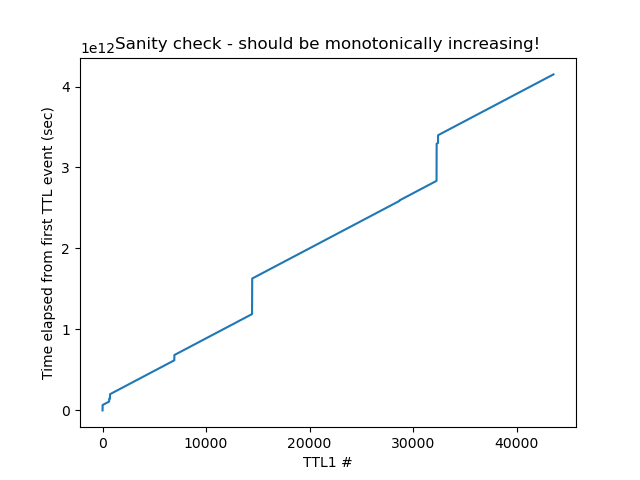

In [46]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [47]:
import tracefc.io.traceio as traceio

if "training" in str(sess.basepath):
    # For tone habituation
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))
    
    # For CS+ during training
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="training", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
elif "recall" in str(sess.basepath):
    # For tone recall CS+
    cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected')
    print(cs_starts.head(6))
    
    # For control tone recall CS-
    csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected')
    print(csn_starts.head(6))

15 CS+ events detected
      Time (s)      Event                     Timestamp
9    60.992706  CS1_start 2022-01-21 12:39:00.826961060
11  140.927233  CS2_start 2022-01-21 12:40:20.761488219
13  204.874969  CS3_start 2022-01-21 12:41:24.709224482
15  264.824631  CS4_start 2022-01-21 12:42:24.658886214
17  325.753973  CS5_start 2022-01-21 12:43:25.588227530
19  388.704585  CS6_start 2022-01-21 12:44:28.538840314
12 CS- events detected
      Time (s)      Event                     Timestamp
5    60.840526  CS1_start 2022-01-21 13:05:10.721559627
7   128.764897  CS2_start 2022-01-21 13:06:18.645930870
9   194.714935  CS3_start 2022-01-21 13:07:24.595968587
11  261.665613  CS4_start 2022-01-21 13:08:31.546646936
13  337.597110  CS5_start 2022-01-21 13:09:47.478144033
15  404.545281  CS6_start 2022-01-21 13:10:54.426315410


In [48]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2022-01-21 12:30:50.731508-05:00
start time = 2022-01-21 12:30:50.731508-05:00
Dropping last 7424 frames per dropped_end_frames.txt file
start time = 2022-01-21 12:36:53.592984-05:00
start time = 2022-01-21 12:59:46.424053-05:00
start time = 2022-01-21 13:28:32.606720-05:00


Recording                            Datetime Condition  nframe_dat  \
0          0    2022-01-21 12:30:50.731508-05:00     start           0   
1          0 2022-01-21 12:32:49.541074667-05:00      stop     3564287   
2          1 2022-01-21 12:34:38.989641333-05:00     start     3564288   
3          1 2022-01-21 12:35:11.074941333-05:00      stop     4526847   
4          2    2022-01-21 12:36:53.592984-05:00     start     4526848   
5          2 2022-01-21 12:57:43.478817333-05:00      stop    42023423   
6          3    2022-01-21 12:59:46.424053-05:00     start    42023424   
7          3    2022-01-21 13:24:41.139753-05:00      stop    86864895   
8          4    2022-01-21 13:28:32.606720-05:00     start    86864896   
9          4 2022-01-21 13:46:59.704286667-05:00      stop   120077823   

      dat_time  nframe_eeg   eeg_time  
0     0.000000           0     0.0000  
1   118.809567      148511   118.8088  
2   118.809600      148512   118.8096  
3   150.894900      188618   150.8944  
4   150.894933      188619   150.8952  
5  1400.780767     1750975  1400.7800  
6  1400.780800     1750976  1400.7808  
7  2895.496500     3619370  2895.4960  
8  2895.496533     3619371  2895.4968  
9  4002.594100     5003242  4002.5936

In [49]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = pd.Timedelta(0.8, unit="seconds")
cs_oe_start_df = traceio.trace_ttl_to_openephys(cs_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
cs_oe_stop_df = traceio.trace_ttl_to_openephys(cs_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
# Convert to times in combined eeg file
cs_starts_combined = oeio.recording_events_to_combined_time(cs_oe_start_df, sync_df)
cs_stops_combined = oeio.recording_events_to_combined_time(cs_oe_stop_df, sync_df)

csn_oe_start_df = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)
csn_oe_stop_df = traceio.trace_ttl_to_openephys(csn_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)

# Convert to times in combined eeg file
csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)
csn_stops_combined = oeio.recording_events_to_combined_time(csn_oe_stop_df, sync_df)

start time lag: mean = -0.5872398221333335, std = 0.0013713736007565883
start time lag: mean = -0.5887733233999999, std = 0.00013625709196786435
start time lag: mean = -0.4215331420000001, std = 0.00017972138044762675
start time lag: mean = -0.4226918540833333, std = 0.00013141926171571328


/data/GitHub/TraceFC/tracefc/io/traceio.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace_cs_sync_df.loc[:, "datetimes"] = trace_cs_sync_df["datetimes"].dt.tz_localize(


# Bowen copy below to save CS epoch files!

In [50]:
cs_epochs = Epoch(pd.DataFrame({"start": cs_starts_combined, "stop": cs_stops_combined, "label": "CS+"}))
cs_epochs.save(sess.filePrefix.with_suffix(".csp_epochs.npy"))

/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_denoised.csp_epochs.npy saved


### How to write CS+ to neuroscope event file

In [51]:
cs_tone_recall_epochs = Epoch({"start": cs_starts_combined, "stop": cs_stops_combined, "label": ["CS+"]*len(cs_starts_combined)})
cs_tone_recall_epochs
sess.recinfo.write_epochs(cs_tone_recall_epochs, "cs+")

In [52]:
cs_tone_recall_epochs

15 epochs
Snippet: 
         start        stop label
0  277.541349  287.463849   CS+
1  357.476082  367.413882   CS+
2  421.423949  431.363949   CS+
3  481.373649  491.293416   CS+
4  542.302849  552.243582   CS+

/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/1_tone_recall/new_arena/T0000001.WAV
Mean start lag time of -185.634 sec with std = 0.041 sec. Add lags from wavfile times to get ephys times
Mean stop lag time of -185.922 sec with std = 0.045 sec.


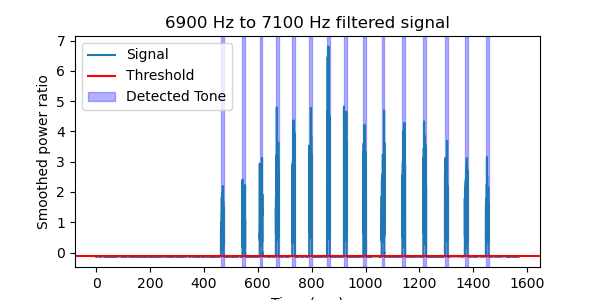

In [53]:
# Detect CS+ in audio recording.
tone_recall_wav = sorted((sess.basepath / "1_tone_recall").glob("**/*.WAV"))[0]
print(tone_recall_wav)

# Get CS+ times and plot to check
cs_wav_epochs = detect_tone(tone_recall_wav, freq_lims=(6900, 7100), thresh=-0.1, tone_length=10, tone_label="CS+", plot_check=True)

# Check that lags are consistent
cs_start_lags = cs_starts_combined - cs_wav_epochs.starts
print(f"Mean start lag time of {np.mean(cs_start_lags):0.3F} sec with std = {np.std(cs_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
cs_stop_lags = cs_stops_combined - cs_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(cs_stop_lags):0.3F} sec with std = {np.std(cs_stop_lags):0.3F} sec.")

Ditto for CS-

/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/2_control_tone_recall/new_arena2/T0000002.WAV
Mean start lag time of 1468.557 sec with std = 0.035 sec. Add lags from wavfile times to get ephys times
Mean stop lag time of 1468.264 sec with std = 0.063 sec.


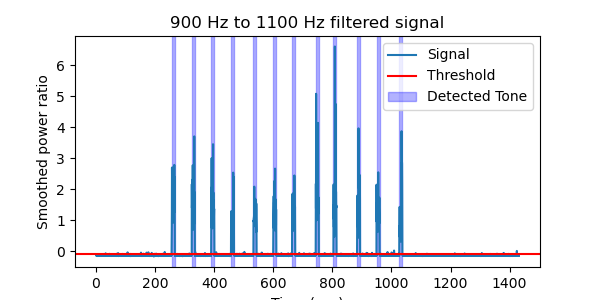

In [54]:
# Detect CS- in audio recording.
control_tone_recall_wav = sorted((sess.basepath / "2_control_tone_recall").glob("**/*.WAV"))[0]
print(control_tone_recall_wav)

# Get CS+ times and plot to check
csn_wav_epochs = detect_tone(control_tone_recall_wav, freq_lims=(900, 1100), thresh=-0.1, tone_length=10, tone_label="CS-", plot_check=True)

# Check that lags are consistent
csn_start_lags = csn_starts_combined - csn_wav_epochs.starts
print(f"Mean start lag time of {np.mean(csn_start_lags):0.3F} sec with std = {np.std(csn_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
csn_stop_lags = csn_stops_combined - csn_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(csn_stop_lags):0.3F} sec with std = {np.std(csn_stop_lags):0.3F} sec.")

Now try to sync to start tone 

/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/3_ctx_recall/shock_box/T0000001.WAV


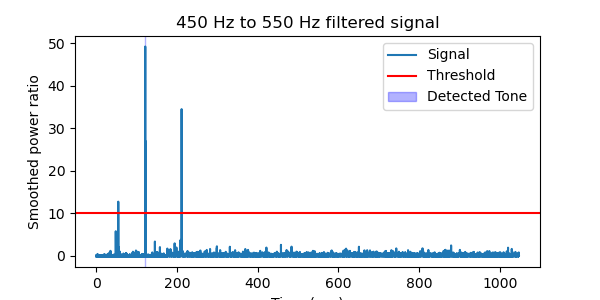

In [55]:
ctx_recall_wav = sorted((sess.basepath / "3_ctx_recall").glob("**/*.WAV"))[0]
print(ctx_recall_wav)

# Get CS+ times and plot to check
start_wav_epochs = detect_tone(ctx_recall_wav, freq_lims=(450, 550), thresh=10, tone_length=0.5, tone_label="start_tone", plot_check=True)

## Sync recorded USV times to ephys file

In [56]:
# Read in USV times from tone recall session
from neuropy.io.usvio import DeepSqueakIO
csp_wav = Path(tone_recall_wav)
usv_detect_file = sorted(tone_recall_wav.parent.glob(f"**/{tone_recall_wav.name[:-4]}*_cell.mat"))[0]

ds_calls = DeepSqueakIO(filename=usv_detect_file)
ds_calls.load_calls()
ds_calls.usv_df

Begin_Time   Freq_Min  Duration  Freq_Range     Score  Accept
0     463.540248  18.375000  3.390000    6.125000  0.538919       0
1     467.582820  18.375000  5.550000    6.125000  0.621996       0
2     607.828336  18.625000  3.370000    5.750000  0.587801       0
3     611.814908  18.500000  5.230000    6.000000  0.561026       0
4     666.988720  18.500000  5.370000    6.000000  0.592376       0
..           ...        ...       ...         ...       ...     ...
214  1562.019267  17.792658  1.054818    4.979317  1.000000       1
215  1563.205016  16.686143  0.851456    6.307135  1.000000       1
216  1564.171144  18.567218  0.892067    4.979317  1.000000       1
217  1565.171306  15.911582  0.602594    9.294726  1.000000       1
218  1565.893555  16.686143  0.672027    8.409514  1.000000       1

[219 rows x 6 columns]

Plot lags vs time to check for drift between ephys and audio recordings and correct if necessary

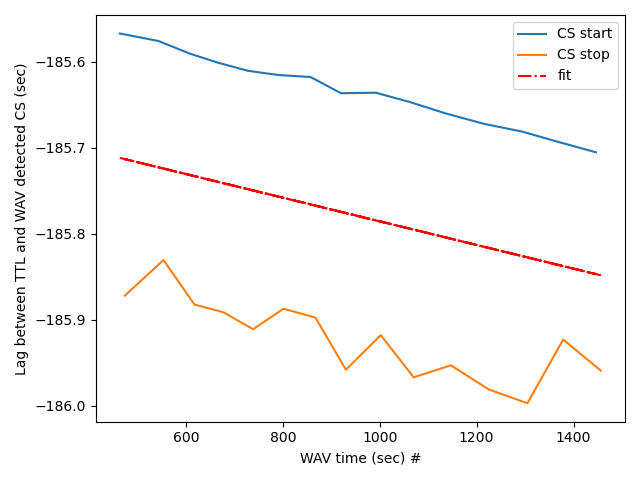

In [57]:
from scipy.linalg import lstsq

_, ax = plt.subplots(layout='tight')
cs_times_wav = np.stack((cs_wav_epochs.starts, cs_wav_epochs.stops), axis=1)
cs_lags_comb = np.stack((cs_start_lags, cs_stop_lags), axis=1)
hl = ax.plot(cs_times_wav, cs_lags_comb)
ax.set_xlabel('WAV time (sec) #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

# Fit function to approximate drift
y = cs_lags_comb.T.reshape(-1)
M = np.stack((np.ones_like(cs_lags_comb.reshape(-1)), cs_times_wav.T.reshape(-1)), axis=1)
p, res, rnk, s = lstsq(M, y)
hfit = ax.plot(cs_times_wav.T.reshape(-1), p[0] + p[1]*cs_times_wav.T.reshape(-1), 'r-.')
hl.extend(hfit)
ax.legend(hl, ('CS start', 'CS stop', 'fit'))

In [58]:
# Sanity check code to output corrected CS times from WAV file to Neuroscope
cs_wav_starts_aligned = cs_wav_epochs.starts + p[0] + p[1]*cs_wav_epochs.starts
cs_wav_stops_aligned = cs_wav_epochs.stops + p[0] + p[1]*cs_wav_epochs.stops
cs_wav_epochs_aligned = Epoch({"start": cs_wav_starts_aligned, "stop": cs_wav_stops_aligned, 
                               "label": ["CS+ from WAV file"]*len(cs_wav_stops_aligned)})


cs_epochs_files = sess.filePrefix.with_suffix(".cs_wav_epochs.npy")
cs_wav_epochs_aligned.save(cs_epochs_files)
sess.recinfo.write_epochs(cs_wav_epochs_aligned, ext="wv+")

/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_denoised.cs_wav_epochs.npy saved


In [59]:
cs_wav_epochs_aligned

15 epochs
Snippet: 
         start        stop              label
0  277.396747  287.622589  CS+ from WAV file
1  357.329247  367.520207  CS+ from WAV file
2  421.282820  431.513212  CS+ from WAV file
3  481.235200  491.443461  CS+ from WAV file
4  542.165256  552.404972  CS+ from WAV file

Now correct that drift and find corrected lags!

In [60]:
# This should eventually be folded into the DeepSqueakIO class!
# Bowen question: 
calls_accept_df = ds_calls.usv_df[ds_calls.usv_df['Accept'] == 1]
call_starts_wav = calls_accept_df['Begin_Time'].values
call_stops_wav = call_starts_wav + calls_accept_df['Duration'].values
calls_accept_df.insert(0, "start", call_starts_wav + p[0] + p[1]*call_starts_wav)
calls_accept_df.insert(1, "stop", call_stops_wav + p[0] + p[1]*call_stops_wav)
calls_accept_df.insert(calls_accept_df.shape[1], "label", "")
good_calls = Epoch(calls_accept_df)

# output to neuroscope and neuropy
sess.recinfo.write_epochs(good_calls, ext="usv")
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
good_calls.save(usv_epochs_file)

/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_denoised.usv_epochs.npy saved


In [61]:
good_calls

203 epochs
Snippet: 
          start         stop   Begin_Time  Freq_Min  Duration  Freq_Range  \
0  1016.930199  1019.321947  1202.743826    15.750  2.392077         6.5   
1  1021.038342  1022.978082  1206.852534    15.625  1.940006         5.5   
2  1023.171727  1024.560180  1208.986212    16.000  1.388644         7.0   
3  1024.772570  1026.313028  1210.587275    16.000  1.540670         7.0   
4  1026.491271  1027.771154  1212.306212    16.000  1.280059         7.0   

      Score  Accept label  
0  0.555882       1        
1  0.574933       1        
2  0.589289       1        
3  0.589289       1        
4  0.589289       1        

## Save notebook to working directory

In [62]:
from neuropy.core.session import ProcessData

def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

## Read in movement data

## Read in deeplabcut data

In [63]:
import neuropy.io.dlcio as dlcio
dlc_path = '/data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1'
arena_side_pix = 60  # Keep this
arena_side_cm = 25.4  # Update this after measuring!!!
pix2cm = arena_side_cm / arena_side_pix

# Read in DLC data
sess.dlc = dlcio.DLC(dlc_path, pix2cm=pix2cm)

# Smooth position, get timestamps, and get speed
sess.dlc.get_timestamps('ms_webcam', include_str="2_training")
sess.dlc.smooth_pos(bodyparts=["crown_middle", "back_middle"])
sess.dlc.timestamps["Timestamps"] = sess.dlc.timestamps["Timestamps"].dt.tz_localize("America/Detroit")
sess.dlc.get_all_speed()

Using tracking file #1: /data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/1_tone_recall/Finn/gobears/2022_01_21/12_37_59/My_First_WebCam/combined_movie13DLC_resnet50_Newarena_novel1configApr18shuffle1_1030000.h5
Using tracking file #2: /data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/1_tone_recall/Finn/gobears/2022_01_21/12_40_13/My_First_WebCam/combined_movie14DLC_resnet50_Newarena_novel1configApr18shuffle1_1030000.h5
Using tracking file #3: /data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/1_tone_recall/Finn/gobears/2022_01_21/12_48_25/My_First_WebCam/combined_movie15DLC_resnet50_Newarena_novel1configApr18shuffle1_1030000.h5
Using tracking file #4: /data2/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/3_ctx_recall/Take 2022-01-21 01.30.55 PM-Camera 6 (#410112)DLC_resnet50_ShockboxAug23shuffle1_1030000.h5
Multiple videos found - taking mean sample rate from all videos


ValueError: No objects to concatenate